## Proposed Neural Network Architecture

`Version Control: 0.0.1`

In [1]:
__VERSION__ = "0.0.1"

`Prep: Libraries Used`

In [1]:
# Environment related libraries
import io
import os
import warnings

In [2]:
# Web related libraries
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

In [3]:
# Data related libraries
import math
import numpy as np
import pandas as pd

In [5]:
# Type related libraries
from typing import Dict, List, Tuple, Any

In [7]:
# Deep Neural Network related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Metrics related libraries
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score

In [9]:
# Python File dumper
# version 0.0.1.2 revesion 250328

import gzip
import lzma
import pickle
from typing import Any

# Kompress can be:
#  gzip
#  lzma

def save(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Directly save without wrapping.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)
            
def dump(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Dump with wrapper and check.
    """
    wrapper = {}
    wrapper["~attr~"] = "~dump~"
    wrapper["~hash~"] = str(hash(obj))
    wrapper["data"] = obj
    
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(wrapper, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)

def load(filename: str, *, kompress: Any = None) -> Any:
    """
    Load a Python object from a pickle file.
    Generally loading. Try to unwrap if possible
    
    Exception:
        Throw a ValueError when in the dumping mode and failed to
        pass the hash test.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
    else:
        with kompress.open(filename, 'rb') as f:
            obj = pickle.load(f)
    
    # No need to unwrap
    if isinstance(obj, dict) == False:
        return obj
    elif isinstance(obj, dict) == True and obj.get("~attr~", None) is None:
        return obj
    
    # Need to unwrap
    if isinstance(obj, dict) == True and obj.get("~attr~", None) == "~dump~":
        if obj.get("~hash~", None) is None:
            raise ValueError("Corrupted dumpped file. Hash attribute has Nonetype.")
        elif isinstance(obj.get("~hash~", None), str) == False:
            raise ValueError("Corrupted dumpped file. Hash attribute has Non-string type.")
        if obj.get("data", None) is None:
            raise ValueError("Corrupted dumpped file. Data attribute is Nonetype.")
        if obj.get("~hash~", None) != str(hash(obj.get("data"))):
            raise ValueError("Corrupted dumpped file. Data hash mismatched.")
        return obj["data"] 
    
    else:
        return obj


In [10]:
# Disable warnings
warnings.filterwarnings('ignore')

`Section: Load the V3_2 Augmentted Splited Training Data`

In [10]:
# Load the gzip augmented, splited training data

(X_spl_train, X_spl_test, y_spl_train, y_spl_test) = load("./splitready_v3_2_Aug(2821)_train.gz.bin", kompress = gzip)

In [11]:
X_spl_train.shape

(66436, 2, 53, 307)

In [312]:
# Alt: Load it from huggingface url

import pickle
import requests
import io

url = "https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/binary/processed_train_nonaugmented_v3_2.gz.bin"
response = requests.get(url)
(X, y) = load(io.BytesIO(response.content), kompress=gzip)

from sklearn import model_selection

X_spl_train, X_spl_test, y_spl_train, y_spl_test = model_selection.train_test_split(X, y, train_size=0.8, random_state=2821)

In [575]:
# Augment if not yet

# Create augmented data for training
# 3. Future: Enhanced samples:
# 1. The results are swapped after the host and guest are swapped,
# 2. Players in the same position can be randomly mixed

def augment_match_dataset_v3_2(X, y=None,
        *,
        swap_teams: bool = True,
        shuffle_positions: bool = True,
        n_row_shuffles: int = 2,
        include_shuffled_swapped: bool = True,
        random_state: int | None = None,
):
    """
    Data‑augmentation for tensors shaped (n_matches, 2, 53, W).

    Parameters
    ----------
    X : ndarray
        Original tensor from `preprocess_data_v3_2` with shape (N, 2, 53, W).
    y : ndarray | None, default=None
        1‑D label np.array.  Binary (0/1) or 3‑class (0‑draw, 1‑home‑win, 2‑away‑win)
        are both handled automatically.  If ``None`` only `X_aug` is returned.
    swap_teams : bool, default=True
        When ``True`` adds a copy with the two team blocks [home, away]
        swapped to [away, home].
    shuffle_positions : bool, default=True
        Randomly permute players *within* each position block
        (size = 8 + 12 + 12 + 12 + 8 = 52) **without** touching the order of
        the blocks themselves.
    n_row_shuffles : int, default=1
        How many independent shuffles to generate *per* original sample.
    include_shuffled_swapped : bool, default=False
        If ``True`` also produces a “swap‑then‑shuffle” version.
    random_state : int | None
        Seed for reproducibility.

    Returns
    -------
    X_aug : ndarray, shape (N_aug, 2, 53, W)
    y_aug : ndarray, shape (N_aug,)   (only if *y* supplied)
    """
    rng = np.random.default_rng(random_state)

    N, _, R, W = X.shape
    assert R == 53, "Expected second dimension size 53."

    # indices (1–52) for each position group, **within a single 53‑row block**
    pos_idx = {
        "GK":  np.arange(1, 1 + 8),
        "DEF": np.arange(9, 9 + 12),
        "MID": np.arange(21, 21 + 12),
        "ATT": np.arange(33, 33 + 12),
        "MIS": np.arange(45, 45 + 8),
    }

    def _permute_positions(block: np.ndarray) -> np.ndarray:
        """Return a copy where rows inside each position are shuffled."""
        blk = block.copy()
        for idx in pos_idx.values():
            perm = rng.permutation(idx)
            blk[idx] = blk[perm]
        return blk

    # Label‑swap helper
    def _swap_label(lbl):
        # binary {0,1}           → 1 - lbl
        # tri‑class {0,1,2}      → 0 stays, 1 exchanges 2
        if lbl in (0, 1):
            return 1 - lbl
        if lbl in (0, 1, 2):
            return {0: 0, 1: 2, 2: 1}[lbl]
        raise ValueError(
            "Unrecognised label value. "
            "Pass `y=None` or handle labels outside this function."
        )

    # Build the augmented lists
    X_out, y_out = [], []

    for i in range(N):
        x0 = X[i]

        # 1. original
        X_out.append(x0)
        if y is not None:
            y_out.append(y[i])

        # 2. swapped home and away
        if swap_teams:
            x_sw = x0[::-1].copy()        # reverse first axis
            X_out.append(x_sw)
            if y is not None:
                y_out.append(_swap_label(y[i]))

        # 3. row‑shuffles
        if shuffle_positions:
            for _ in range(n_row_shuffles):
                x_sh = x0.copy()
                x_sh[0] = _permute_positions(x_sh[0])   # home
                x_sh[1] = _permute_positions(x_sh[1])   # away
                X_out.append(x_sh)
                if y is not None:
                    y_out.append(y[i])

                # optionally shuffle the swapped version too
                if swap_teams and include_shuffled_swapped:
                    x_sws = x_sw.copy()
                    x_sws[0] = _permute_positions(x_sws[0])
                    x_sws[1] = _permute_positions(x_sws[1])
                    X_out.append(x_sws)
                    if y is not None:
                        y_out.append(_swap_label(y[i]))

    X_aug = np.stack(X_out, axis=0)
    if y is None:
        return X_aug,
    return X_aug, np.asarray(y_out)

X_spl_train, y_spl_train = augment_match_dataset_v3_2(X_spl_train, y_spl_train.flatten())

In [578]:
y_spl_train = y_spl_train.reshape([-1,1])

`Section: Modeling - ResNet Image Structure V New`

In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

ResNet 50 Model with Interaction

In [ ]:
# Legacy Model, too many parameters

class CBAM(nn.Module):
    """
    Channel + Spatial attention (Woo et al. 2018).
    """
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        # Channel‑attention sub‑module
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.LeakyReLU(True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        # Spatial‑attention sub‑module
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size,
                                      padding=kernel_size//2, bias=False)

    def forward(self, x):
        b, c, h, w = x.size()

        # Channel attention
        avg = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_ = F.adaptive_max_pool2d(x, 1).view(b, c)
        ch_att = torch.sigmoid(self.mlp(avg) + self.mlp(max_)).view(b, c, 1, 1)
        x = x * ch_att                        # (B,C,H,W)

        # Spatial attention
        avg = torch.mean(x, dim=1, keepdim=True)          # (B,1,H,W)
        max_, _ = torch.max(x, dim=1, keepdim=True)       # (B,1,H,W)
        sp_att = torch.sigmoid(self.conv_spatial(torch.cat([avg, max_], 1)))
        return x * sp_att


class RowSelfAttention(nn.Module):
    """
    Treat each row (team or player) as a token.  
    Input: (B, C, R, C_)  -> tokens (R, B, C)  ->  output pooled to (B, C)
    """
    def __init__(self, channels, n_heads=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=channels,
                                         num_heads=n_heads,
                                         dropout=dropout,
                                         batch_first=True)
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):                     # x: (B,C,R,C_)
        x = F.adaptive_avg_pool2d(x, (x.size(2), 1)).squeeze(-1)  # (B,C,R)
        x = x.permute(0, 2, 1)                # (B,R,C)
        out, _ = self.mha(x, x, x)
        return self.norm(out + x).mean(dim=1) # (B,C)

# Bottleneck with CBAM
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_ch, out_ch, stride=1, down=None, p=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.conv3 = nn.Conv2d(out_ch, out_ch*self.expansion, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_ch*self.expansion)
        self.cbam  = CBAM(out_ch*self.expansion)
        self.relu  = nn.LeakyReLU(True)
        self.drop  = nn.Dropout2d(p)
        self.down  = down
    
    def forward(self, x):
        idt = x
        out = self.drop(self.relu(self.bn1(self.conv1(x))))
        out = self.drop(self.relu(self.bn2(self.conv2(out))))
        out = self.bn3(self.conv3(out))
        if self.down is not None:
            idt = self.down(x)
        out = self.cbam(out) + idt
        return self.relu(out)

# ResNetPanelInteraction
class ResNetPanelInteraction(nn.Module):
    """
    * 2 raw panels -> + diff -> + product -> 4 channels.
    * ResNet‑50 depth (3‑4‑6‑3) bottlenecks with CBAM in every block.
    * Row‑wise Transformer before classifier.
    """
    def __init__(self, num_classes=3, base_channels=64, p=0.2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(4, base_channels, 7, 2, 3, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(True),
            nn.MaxPool2d(3, 2, 1)
        )
        # Residual stages 
        self.in_ch = base_channels
        self.layer1 = self._make_layer(16,  3, p)
        self.layer2 = self._make_layer(32,  4, p, stride=2)
        self.layer3 = self._make_layer(64,  6, p, stride=2)
        self.layer4 = self._make_layer(128, 3, p, stride=2)

        # Row‑level attention and head 
        self.row_att  = RowSelfAttention(128*Bottleneck.expansion)
        self.drop     = nn.Dropout(p)
        self.fc       = nn.Linear(128*Bottleneck.expansion, num_classes)

    def _make_layer(self, out_ch, blocks, p, stride=1):
        down = None
        if stride != 1 or self.in_ch != out_ch * Bottleneck.expansion:
            down = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch*Bottleneck.expansion,
                          1, stride, bias=False),
                nn.BatchNorm2d(out_ch*Bottleneck.expansion)
            )
        layers = [Bottleneck(self.in_ch, out_ch, stride, down, p)]
        self.in_ch = out_ch * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_ch, out_ch, p=p))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Explicit panel interaction up‑front
        diff = x[:, 0:1] - x[:, 1:2]          # (B,1,R,C)
        prod = x[:, 0:1] * x[:, 1:2]          # (B,1,R,C)
        x    = torch.cat([x, diff, prod], 1)  # (B,4,R,C)

        x = self.stem(x)                  # (B, base, R/4, C/4)
        x = self.layer1(x)                # (B, 64, ...)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)                # (B, 512, r, c)

        # Row‑wise self‑attention
        x = self.row_att(x)               # (B,512)

        return self.fc(self.drop(x))

    def l1_penalty(self, lambda_):
        return lambda_ * sum(p.abs().sum() for p in self.parameters())


In [ ]:
# Legacy Model, too many parameters

# ResNetSimpleInteraction
class ResNetSimpleInteraction(nn.Module):
    def __init__(self, num_classes: int = 3, base_channels: int = 64, dropout_prob: float = 0.1):
        super().__init__()

        # 2 raw panels + difference + product -> 4 channels
        self.stem = nn.Sequential(
            nn.Conv2d(4, base_channels, kernel_size=7,
                      stride=2, padding=3, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Bottleneck block 1
        in_ch  = base_channels
        out_ch = base_channels
        # channels after expansion = out_ch * 4
        down1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch * Bottleneck.expansion,
                      kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_ch * Bottleneck.expansion)
        )
        self.block1 = Bottleneck(
            in_ch  = in_ch,
            out_ch = out_ch,
            stride = 1,
            down   = down1,
            p      = dropout_prob
        )   

        # Bottleneck block 2 (stride 2)
        in_ch  = out_ch * Bottleneck.expansion             # 4·base
        out_ch = base_channels * 2                         # 2·base
        down2  = nn.Sequential(
            nn.Conv2d(in_ch, out_ch * Bottleneck.expansion,
                      kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_ch * Bottleneck.expansion)
        )
        self.block2 = Bottleneck(
            in_ch  = in_ch,
            out_ch = out_ch,
            stride = 2,
            down   = down2,
            p      = dropout_prob
        )  

        final_channels = out_ch * Bottleneck.expansion      # 8·base

        # Row‑wise Transformer head
        self.row_att = RowSelfAttention(final_channels)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc      = nn.Linear(final_channels, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 2, R, C)  – two related panels
        diff = x[:, 0:1] - x[:, 1:2]           # (B,1,R,C)
        prod = x[:, 0:1] * x[:, 1:2]           # (B,1,R,C)
        x    = torch.cat([x, diff, prod], dim=1)  # (B,4,R,C)

        x = self.stem(x)       # (B, base, R/4, C/4)
        x = self.block1(x)
        x = self.block2(x)     # (B, final_channels, r, c)

        x = self.row_att(x)    # (B, final_channels)
        x = self.dropout(x)
        return self.fc(x)

    def l1_penalty(self, lambda_val: float):
        return lambda_val * sum(p.abs().sum() for p in self.parameters())

In [ ]:
# Proposed Architecture

# Row‑wise self‑attention pooling simplified version
class RowSelfAttentionSimple(nn.Module):
    """
    Turns a (B, C, H, W) tensor into a (B, C) embedding by
    attending *within each row* (H positions).
    """
    def __init__(self, dim, heads=4, p=0.3):
        super().__init__()
        self.heads = heads
        self.mha   = nn.MultiheadAttention(dim, heads, batch_first=True, dropout=p)
        self.norm  = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.mean(-1)               # ↓ collapse columns → (B, C, H)
        x = x.permute(0, 2, 1)       # (B, H, C) = sequence len H, embed C

        attn_out, _ = self.mha(x, x, x)
        x = self.norm(attn_out + x)  # residual & LN
        return x.mean(1)             # global average over rows → (B, C)


# Simpler CNN Baseline
class SimplePanelCNN(nn.Module):
    """
    • 4‑channel input (A, B, A–B, A·B)
    • 3 Conv‑BN‑ReLU blocks (32‑, 64‑, 128‑channel)
    • Row‑wise self‑attention pooling
    • 1 FC classifier head
    """
    def __init__(self, num_classes=3, base=32, p=0.3, heads=16):
        super().__init__()

        def block(in_ch, out_ch, pool):
            layers = [
                nn.Conv2d(in_ch, out_ch, 3, 1, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(inplace=True)
            ]
            if pool:
                layers.append(nn.MaxPool2d(2))
            return nn.Sequential(*layers)

        self.stem = block(4,       base,       pool=True)   # ½ spatial
        self.conv1 = block(base,   base*2,     pool=True)   # ¼ spatial
        self.conv2 = block(base*2, base*4,     pool=False)  # ¼ spatial, deeper reps

        self.row_att = RowSelfAttentionSimple(base*4, heads, p)
        self.drop    = nn.Dropout(p)
        self.fc      = nn.Linear(base*4, num_classes)

    def forward(self, x):
        # Explicit panel interaction (A, B, A–B, A·B)
        diff = x[:, 0:1] - x[:, 1:2]
        prod = x[:, 0:1] * x[:, 1:2]
        x    = torch.cat([x, diff, prod], 1)        # (B, 4, H, W)

        # Feature extractor
        x = self.stem(x)
        x = self.conv1(x)
        x = self.conv2(x)

        # Row‑wise attention pooling + classifier
        x = self.row_att(x)                         # (B, C)
        x = self.drop(x)
        return self.fc(x)

    def l1_penalty(self, lm):
        return lm * sum(p.abs().sum() for p in self.parameters())


In [ ]:
# Simplest Benchmark

class Simplest(nn.Module):

    def __init__(self, num_classes: int = 3, base: int = 64, p: float = 0.3, num_layers: int = 1):
        super().__init__()

        self.seq_len   = 307          # W  (fixed in your data)
        self.feat_dim  = 4 * 53       # C * H = 212
        self.lstm      = nn.LSTM(input_size=self.feat_dim,
                                 hidden_size=base,
                                 num_layers=num_layers,
                                 dropout=p if num_layers > 1 else 0.,
                                 batch_first=True)        # (B, T, F)
        self.drop      = nn.Dropout(p)
        self.fc_out    = nn.Linear(base, num_classes)

    def forward(self, x):

        diff = x[:, 0:1] - x[:, 1:2]
        prod = x[:, 0:1] * x[:, 1:2]
        x    = torch.cat([x, diff, prod], 1)              # (B, 4, 53, 307)

        B, C, H, W = x.shape                               # C=4, H=53, W=307
        x = x.reshape(B, C * H, W)                         # (B, 212, 307)
        x = x.transpose(1, 2)                              # (B, 307, 212)

        _, (h_n, _) = self.lstm(x)                         # h_n: (num_layers, B, base)
        emb = self.drop(h_n[-1])                           # last layer’s hidden state
        logits = self.fc_out(emb)                          # (B, num_classes)
        return logits

    def l1_penalty(self, lm: float = 1e-4):
        return lm * sum(p.abs().sum() for p in self.parameters())

Trainer and Tester Utilities

In [19]:
# Model evaluating for resnet model
def evaluate_model_resnet(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    all_probs = []  # Store probabilities for ROC AUC

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # If labels are one-hot encoded, convert to class indices.
            if labels.ndim > 1 and labels.size(1) > 1:
                labels = labels.argmax(dim=1)
                
            outputs = model(inputs)  # Raw logits
            
            # Convert logits to probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)  # Get probabilities
            _, predicted = torch.max(outputs, 1)  # Get predicted class index
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")

    return all_preds, all_labels, accuracy, precision


In [20]:
# Model training for resnet model
def train_model_resnet(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10, l1_lambda=1e-8):
    model.train()
    
    for epoch in range(num_epochs):
            model.train()
            running_train_loss = 0.0
            for inputs, labels in train_loader:
                  # Labels must be long dtype
                inputs, labels = inputs.to(device).float(), labels.to(device).long()
                optimizer.zero_grad()
                outputs = model(inputs)  # (batch_size, num_classes)
                # Add l1 penalty
                loss = criterion(outputs, labels.squeeze(1))
                if hasattr(model, "l1_penalty"):
                     loss += model.l1_penalty(l1_lambda)
                # No need for one-hot encoding
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()

            avg_train_loss = running_train_loss / len(train_loader)

            # Evaluate test loss
            model.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device).float(), labels.to(device).long()
                    outputs = model(inputs)
                    # No need to add l1 penality
                    loss = criterion(outputs, labels.squeeze(1))
                    running_test_loss += loss.item()

            avg_test_loss = running_test_loss / len(test_loader)
           
            pred, lbs, acc, prec = evaluate_model_resnet(model, test_loader, device = device)
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f} | Test Acc: {acc:.6f} | Test Prec: {prec:.6f}")


In [608]:
device = "cuda"
X_train_ts = torch.tensor(X_spl_train, dtype=torch.float32, device=device)
X_test_ts = torch.tensor(X_spl_test, dtype=torch.float32, device=device)
y_train_ts = torch.tensor(y_spl_train, dtype=torch.float32, device=device)
y_test_ts = torch.tensor(y_spl_test, dtype=torch.float32, device=device)

In [609]:
# Create DataLoaders
batch_size = 256
train_dataset = TensorDataset(X_train_ts, y_train_ts)
test_dataset = TensorDataset(X_test_ts, y_test_ts)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Build and train the Model

In [23]:
# Create weights for unbalanced dataset
weights = torch.tensor([1/0.35, 1/0.5, 1/0.15])
weights = weights / weights.mean() 
weights = weights.to(device)

In [20]:
# Initialize Standard Model
model = ResNetSimpleInteraction().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05, weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [743]:
# Alternative Simple Model
model = SimplePanelCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05, weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [722]:
# Alternative Simplest Model without Weights
model = Simplest().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

In [741]:
# Move the model to two GPUs
model = nn.DataParallel(model, device_ids=[0, 1])

In [744]:
# Clear cache

import gc


gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

Train The Standard Model

In [ ]:
# Train the model using the trainer
num_epochs = 32
train_model_resnet(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

In [ ]:
# Continue to train the model
num_epochs = 4
train_model_resnet(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=num_epochs)

Evaluating The model

In [ ]:
# Metrics on training set
nn_pred, nn_true, acc_nn, prec_nn = evaluate_model_resnet(model, train_loader, device)
acc_nn, prec_nn

In [ ]:
# Metrics on testing set
nn_pred, nn_true, acc_nn, prec_nn = evaluate_model_resnet(model, test_loader, device)
acc_nn, prec_nn

In [29]:
def torch_save_load(filepath:str, model=None, mode="save", device="cuda"):

    if mode == "save":
        if model is None:
            raise ValueError("When saving a model, you cannot leave it None.")
        torch.save(model, filepath)
        return model
    elif mode == "load":
        if model is not None:
            raise ValueError("When loading a model, you cannot pass an initial model.")
        model = torch.load(filepath, weights_only=False)
        model.to(device)
        return model


In [165]:
_ = torch_save_load("./ResNetWithInterSimple_v3_2_ckpt0160.pt", model, mode = "save")

In [149]:
# model = torch_save_load("./ResNetWithInterSimple_v3_2_ckpt0160.pt", mode = "load")

In [395]:
_ = torch_save_load("./SimpleCNN_v3_2_ckpt0086.pt", model, mode = "save")

In [ ]:
# model = torch_save_load("./SimpleCNN_v3_2_ckpt0086.pt", mode = "load")

`Section - Import and Testing`

In [742]:
# Load the model back
model = torch_save_load("./SimpleCNN_v3_2_ckpt0026.pt", mode = "load")

In [300]:
# Load the dataset

import pickle
import requests
import io

url = "https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/binary/processed_test_v3_2.gz.bin"
response = requests.get(url)
X_valid = load(io.BytesIO(response.content), kompress=gzip)

In [38]:
# Clear cache

import gc


gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [301]:
# Create a feature tensor
X_valid_tensor = torch.tensor(X_valid[0][0], device="cuda:1", dtype=torch.float32)

In [308]:
# Predict by the model
y_subm_ts = torch.randint(0, 3, (X_valid_tensor.shape[0],))
subm_dataset = TensorDataset(X_valid_tensor, y_subm_ts)
subm_loader = DataLoader(subm_dataset, batch_size=256, shuffle=False)
nn_pred, acc_nn, f1_nn, auc_nn = evaluate_model_resnet(model, subm_loader, "cuda")


In [304]:
# Reconstruct a dataframe
def reconstruct_df_v3_2(data):
    nn_pred_onehot = torch.nn.functional.one_hot(torch.tensor(data), num_classes=3)
    adf = pd.DataFrame(np.array(nn_pred_onehot))
    adf.index = range(12303, 37671)
    adf["ID"] = range(12303, 37671)
    adf.columns = ["DRAW", "HOME_WINS", "AWAY_WINS",  "ID"]
    adf = adf[["ID", "HOME_WINS", "DRAW", "AWAY_WINS"]]
    return adf

In [ ]:
subm_df = reconstruct_df_v3_2(nn_pred)
subm_df

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'HOME_WINS'}>],
       [<Axes: title={'center': 'DRAW'}>,
        <Axes: title={'center': 'AWAY_WINS'}>]], dtype=object)

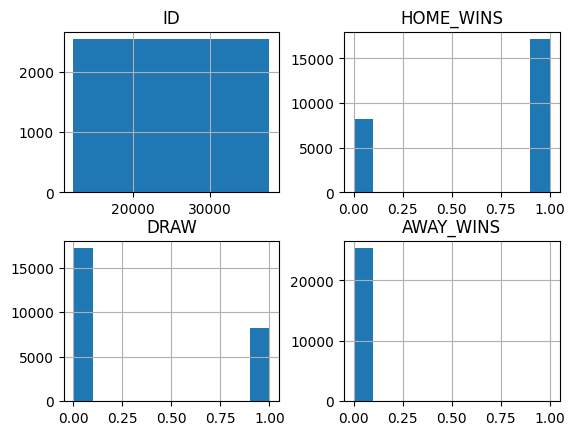

In [310]:
subm_df.hist()

In [311]:
# Save the df
subm_df.to_csv("SimpleCNN_retrain2_ckpt39_subm.csv", index=False)